# 21cmFASTv4 Database usage tutorial

Tutorial for using the [21cmFASTv4](https://github.com/nikos-triantafyllou/21cmFAST) database created with https://github.com/nikos-triantafyllou/Database-21cmFASTv4 <br>
**Author:** Nikolaos (Nikos) Triantafyllou<br>
**Date:** January 2025

---


### Table of Contents

* [0. Info](#info)
    * [0.1 Imports](#imports)
    * [0.2 Loading a file and reading general information](#loading)
* [1. Simulation Parameters](#simulationparams)
* [2. Lightcones](#lightcones)
    * [2.1 Power Spectra](#powerspectra)
* [3. Coeval Data](#coevaldata)
    * [3.1 $x_{HI},T_{kin\_all\_gas}$, brightness_temp](#first3)
    * [3.2 tau_e](#taue)
    * [3.3 HMF (a)](#hmf)
    * [3.4 UV Luminosity Function (a)](#turnoverluminosity)
* [4. Halo Data](#halodata)
    * [4.1 HMF (b)](#hmf2)
    * [4.2 UV Luminosity Function (b)](#uvlf2)
    * [4.3 Stellar Halo Mass Relation (Mstar vs Mhalo)](#starrng)
    * [4.4 Star Formation Main Sequence (SFR vs Mstar)](#sfrrng)
    

---

# 0. Info <a class="anchor" id="info"></a>

Each file is saved in a `hdf5` format and named after an ID that corresponds to the random seed used to run the database, e.g. `id_22.h5`. Currently located at `/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/data/` on Trantor HPC system. <br>
Indicative simulations run with fiducial parameters or with only varying 1 parameter can be found at `/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/`.

Fiducial parameters can be found at the `FIDUCIAL_PARAMETERS.json` github file. To see what the parameters are check [21cmFAST's github](https://github.com/nikos-triantafyllou/21cmFAST)  or [documentation](https://21cmfast.readthedocs.io/en/latest/) (be sure to look at the correct version).

Varying parameters are the following:<br>

```python
"SIGMA_8", 
"L_X",
"NU_X_THRESH",
"F_STAR10",
"ALPHA_STAR",
"F_ESC10",
"ALPHA_ESC",
"t_STAR",
"SIGMA_SFR_LIM",
"M_TURN" 
```

As well as `random_seed`, `N_threads` and their mini-halos counterparts (dependent on the previous params in a way specified in `FIDUCIAL_PARAMETERS.json`)


**Sampling**<br>
First 2000 simulations were run based on a Latin Hypercube Sampling (LHS) according to the uniform distributions as described in the `LHS_sampler.py` file on github.
Following simulations were run based on a chi^2 effective likelihood on luminosity functions using these initial 2000 simulations.


**File structure**<br>
Files have the structure drawn in `DatabaseTree.pdf` on github:

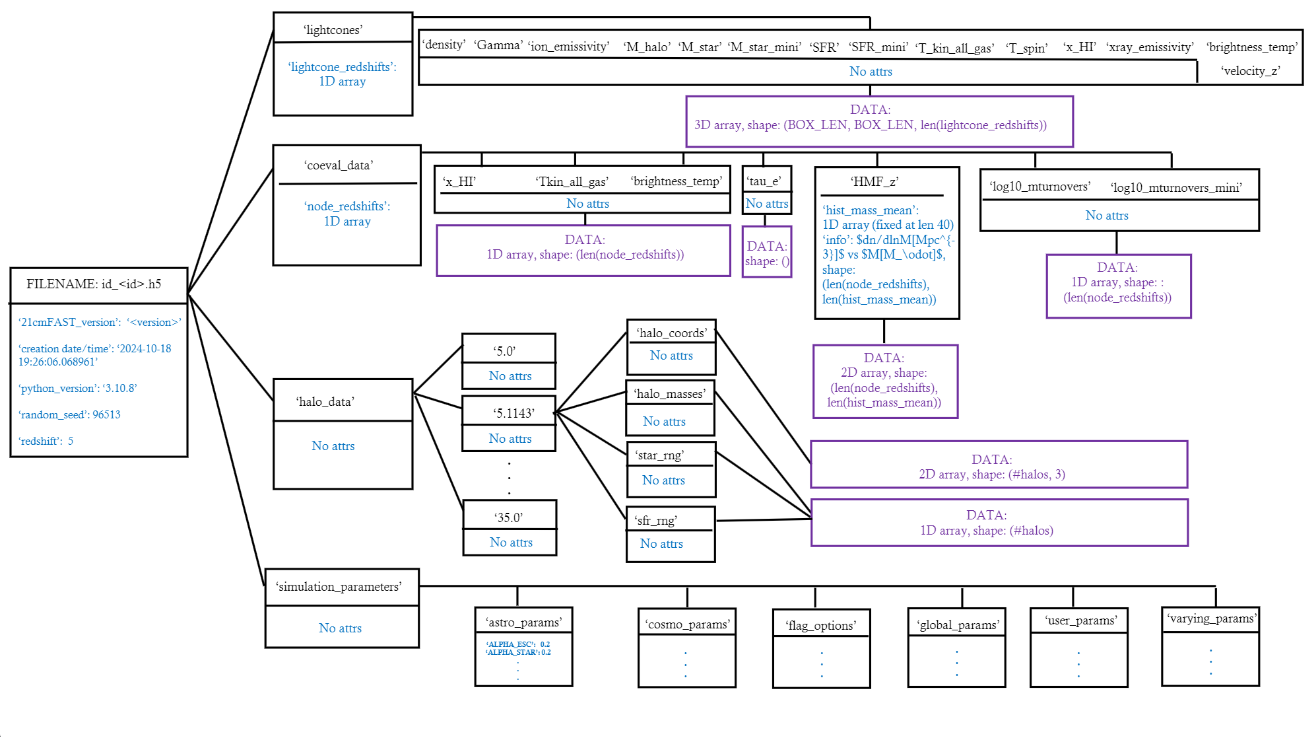

### 0.1 Imports <a class="anchor" id="imports"></a>

In [1]:
import h5py    
import numpy as np  
import matplotlib.pyplot as plt
import py21cmfast_tools as p21c_tools
import py21cmfast as p21c

from importlib import reload 
import d_plotting
import d_get_properties

EoR_color already loaded


### 0.2 Loading a file and reading general information <a class="anchor" id="loading"></a>

In [2]:
# Load the file
hdf = h5py.File('/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/data/id_22.h5', 'r')

# And let's see some general information
dict(hdf.attrs)

{'21cmFAST_version': '3.4.1.dev494+gf8b15152',
 'creation date/time': '2024-12-31 16:54:56.713934',
 'python_version': '3.11.6',
 'random_seed': 22,
 'redshift': 5}

## 1. Simulation Parameters <a class="anchor" id="simulationparams"></a>

In [3]:
# Let's see what the varying parameters are
dict(hdf['simulation_parameters']['varying_params'].attrs)
# dict(id_22['simulation_parameters']['astro_params'].attrs)
# dict(id_22['simulation_parameters']['cosmo_params'].attrs)
# dict(id_22['simulation_parameters']['flag_options'].attrs)
# dict(id_22['simulation_parameters']['global_params'].attrs)
# dict(id_22['simulation_parameters']['user_params'].attrs)

{'ALPHA_ESC': 0.03062895133885757,
 'ALPHA_STAR': 0.31480428096680224,
 'F_ESC10': -1.47325660509868,
 'F_STAR10': -2.6400886743488026,
 'L_X': 38.99028759734818,
 'M_TURN': 7.394111881295119,
 'NU_X_THRESH': 1436.47730818446,
 'SIGMA_8': 0.8121220321531987,
 'SIGMA_SFR_LIM': 0.394076465304313,
 'random_seed': 22,
 't_STAR': 0.4933866791966658}

## 2. Lightcones <a class="anchor" id="lightcones"></a>

Let's plot the brightness temperature

In [4]:
# Let's get the lightcone 
Tb_lightcone = hdf['lightcones']['brightness_temp'][:]
print('Lightcone shape:', Tb_lightcone.shape)

# And the redshifts corresponding to the 3rd dimention of the lightcone
lightcone_redshifts = dict(hdf['lightcones'].attrs)['lightcone_redshifts']

Lightcone shape: (200, 200, 2553)


EoR_color already loaded


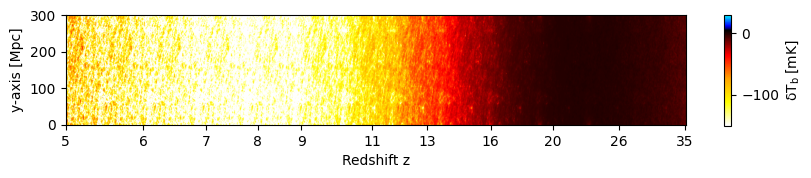

In [5]:
# Let's plot it!
from n_plotting import plot_lc
plot_lc(Tb_lightcone, lightcone_redshifts);

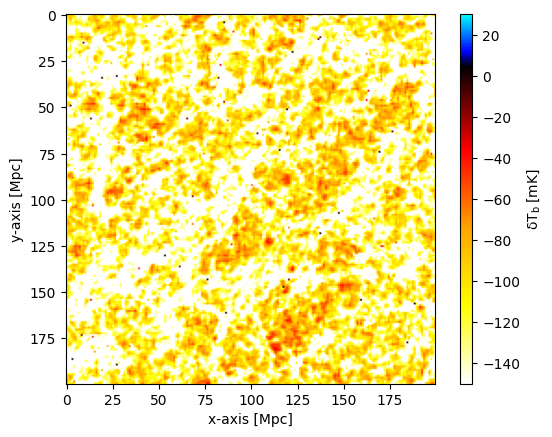

In [6]:
# Maybe also a slice
from n_plotting import plot_box_slice
plot_box_slice(Tb_lightcone[:,:,134]);

And now let's plot the density

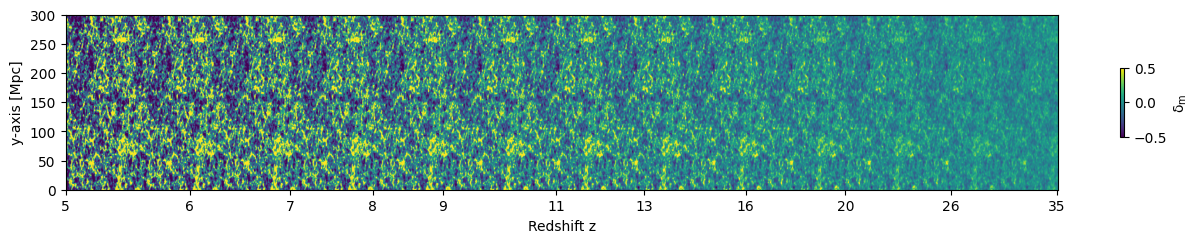

In [7]:
# Let's get the lightcone 
density_lightcone = hdf['lightcones']['density'][:]

# Let's plot it!
fig, ax = plt.subplots(figsize=((16,5)))
plt.imshow(density_lightcone[:,7,], cmap='viridis', extent=[0,2553,0,300], norm='linear',vmin=-0.5,vmax=0.5)
ax.set_aspect(1.5)

# redshift_arr = lightcone_redshifts
zs= np.concatenate((np.arange(5,15,1), np.arange(15,23,2)))
zs = np.concatenate((zs,np.arange(23,37,3)))
zs=[5,6,7,8,9,11,13,16,20,26,35]

z_positions=[]
for z in zs:
    z_positions.append( np.where(abs(lightcone_redshifts-z) ==  min(abs(lightcone_redshifts-z)))[0][0] )

ax.set_xticks(ticks = z_positions, labels= zs)

plt.colorbar(shrink=0.18, aspect=16, label=r'$\rm \delta_m$')

plt.xlabel('Redshift z')
plt.ylabel('y-axis [Mpc]')
#     plt.close()
plt.show()

### 2.1 Power spectra <a class="anchor" id="powerspectra"></a>

In [22]:
import d_plotting
ps = p21c_tools.calculate_ps(lc=Tb_lightcone,
                        lc_redshifts = lightcone_redshifts,
                        box_length = 300.0,
                        #    box_side_shape = 200,
                        calc_1d = True,
                        calc_2d = False,
                        )

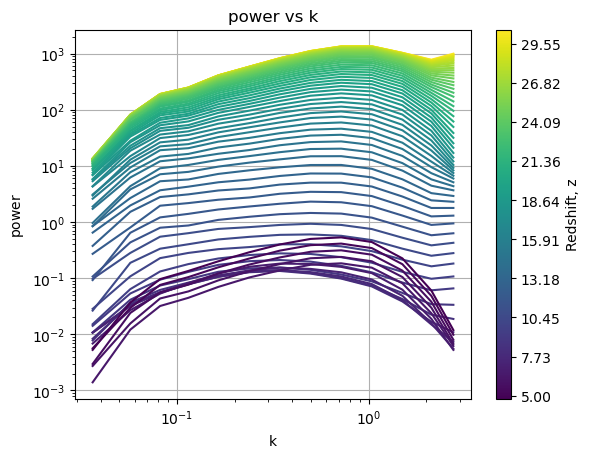

In [20]:
fig = d_plotting.plot_ps_1D(ps)

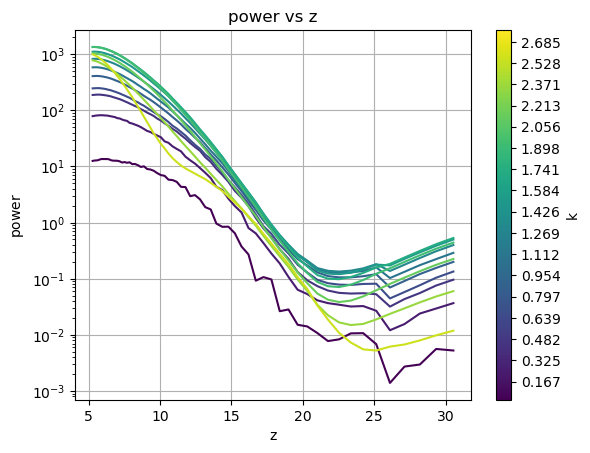

In [21]:
fig = d_plotting.plot_ps_1D_2(ps)

## 3. Coeval data <a class="anchor" id="coevaldata"></a>

### 3.1) $x_{HI}$, $T_{kin\_all\_gas}$, brightness_temp <a class="anchor" id="first3"></a>

In [61]:
# Let's get the neutral fraction
x_HI_coev = hdf['coeval_data']['x_HI'][:]
print('Coeval quantity shape:', x_HI_coev.shape)

# And the redshifts corresponding to the 92 values of the previus array
node_redshifts = dict(hdf['coeval_data'].attrs)['node_redshifts']
print('Node redshifts shape:', node_redshifts.shape)

Coeval quantity shape: (92,)
Node redshifts shape: (92,)


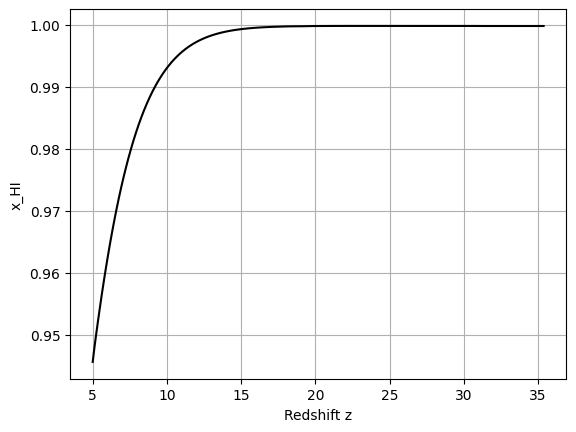

In [62]:
# Let's plot it!
fig, ax = plt.subplots()
plt.plot(node_redshifts, x_HI_coev, color='black')
plt.xlabel('Redshift z')
plt.ylabel('x_HI')
plt.grid()
plt.show()

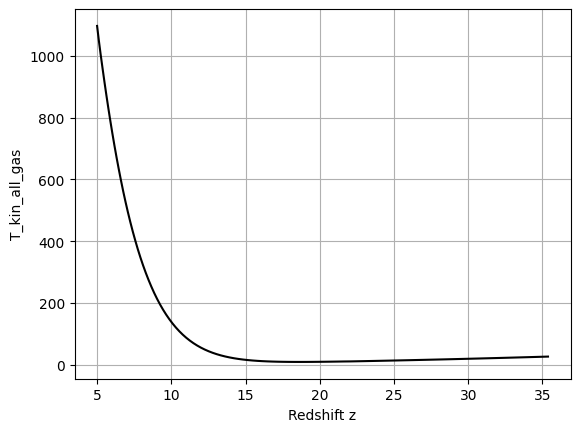

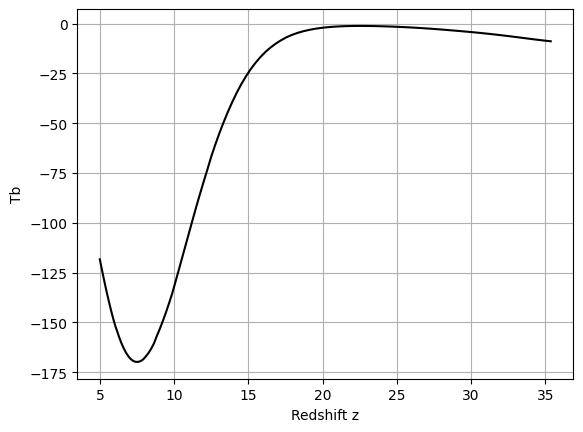

In [59]:
# Let's plot the other 2 quantities
T_kin_all_gas_coev = hdf['coeval_data']['T_kin_all_gas'][:]
Tb_coev = hdf['coeval_data']['brightness_temp'][:]

# Let's plot them!
fig, ax = plt.subplots()
plt.plot(node_redshifts, T_kin_all_gas_coev, color='black')
plt.xlabel('Redshift z')
plt.ylabel('T_kin_all_gas')
plt.grid()
plt.show()

fig, ax = plt.subplots()
plt.plot(node_redshifts, Tb_coev, color='black')
plt.xlabel('Redshift z')
plt.ylabel('Tb')
plt.grid()
plt.show()

### 3.2) tau_e <a class="anchor" id="taue"></a>

In [27]:
# The optical depth
tau_e =np.array( hdf['coeval_data']['tau_e'] )
print(tau_e)

0.03148088976740837


### 3.3) HMF <a class="anchor" id="hmf"></a>

In [56]:
# Get the data from the file
node_redshifts = hdf['coeval_data'].attrs['node_redshifts']
hist_mass_mean = hdf['coeval_data']['HMF_z'].attrs['hist_mass_mean']
HMF_arr = hdf['coeval_data']['HMF_z'][:]

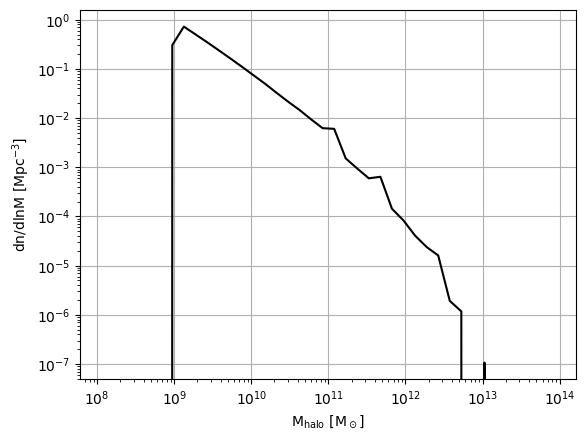

In [57]:
# Plot 1 hmf 
plt.plot(hist_mass_mean, HMF_arr[91], color='black')

# Make the plot pretty
plt.xlabel(r'$\rm M_{\rm halo}~[M_\odot]$')
plt.ylabel(r'$\rm dn/dlnM~[Mpc^{-3}]$')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

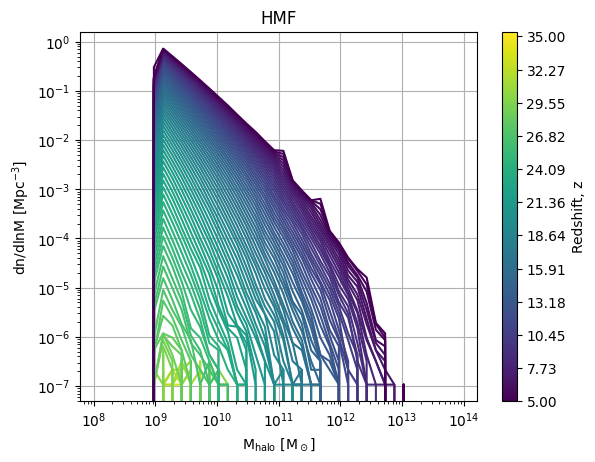

In [13]:
# Or all of them!
d_plotting.plot_hmf_z(HMF_arr, hist_mass_mean, node_redshifts)

### 3.4) Turnover Masses / Luminosity Functions <a class="anchor" id="turnoverluminosity"></a>

In [15]:
import py21cmfast as p21c

In [16]:
user_params = dict(hdf['simulation_parameters']['user_params'].attrs)
cosmo_params = dict(hdf['simulation_parameters']['cosmo_params'].attrs)
astro_params = dict(hdf['simulation_parameters']['astro_params'].attrs)
flag_options = dict(hdf['simulation_parameters']['flag_options'].attrs)


input_params_struct = p21c.InputParameters(
                cosmo_params=p21c.CosmoParams.new(cosmo_params),
                astro_params=p21c.AstroParams.new(astro_params),
                user_params=p21c.UserParams.new(user_params),
                flag_options=p21c.FlagOptions.new(flag_options),
                random_seed=hdf.attrs['random_seed'],
                node_redshifts = hdf['coeval_data'].attrs['node_redshifts'],
            )

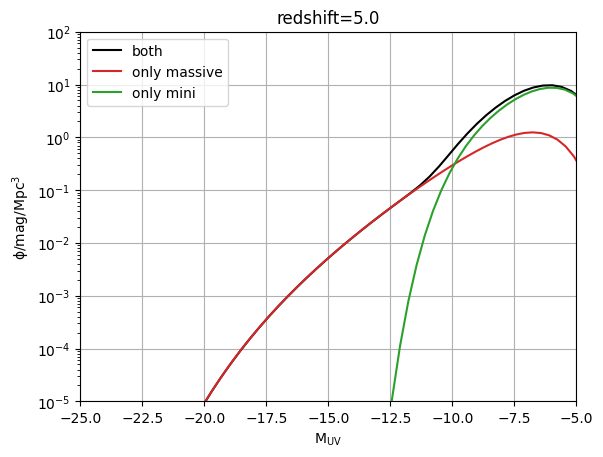

In [17]:
node_redshifts_fid = hdf['coeval_data'].attrs['node_redshifts']
log10_mturnovers = hdf['coeval_data']['log10_mturnovers'][:]
log10_mturnovers_mini = hdf['coeval_data']['log10_mturnovers_mini'][:]

z_uv=node_redshifts_fid  
LF_arr=p21c.compute_luminosity_function(
    redshifts = z_uv,
    inputs=input_params_struct,
    nbins=100,
    mturnovers=10**log10_mturnovers,
    mturnovers_mini=10**log10_mturnovers_mini,
    component='both',
)    
LF_arr_0 = LF_arr[0]
LF_arr_1 = LF_arr[1]
LF_arr_2 = LF_arr[2]


z_id=-1

fig, ax = plt.subplots()
ax.plot(LF_arr_0[z_id,:], 10**LF_arr_2[z_id,:]
        # /LF_arr_0[z_id,:]
        , color='black', label='both')
ax.set_xlabel(r'$\rm M_{UV}$')
ax.set_ylabel(r'$\rm \phi /mag/Mpc^3$')
ax.set_title(     label = f'redshift={round(node_redshifts_fid[z_id], 1)}' )

ax.set_xlim((-25,-5))
ax.set_ylim((1e-5,1e2))
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.grid()


LF_arr=p21c.compute_luminosity_function(
    redshifts = z_uv,
    inputs=input_params_struct,
    nbins=100,
    mturnovers=10**log10_mturnovers,
    mturnovers_mini=10**log10_mturnovers_mini,
    component='acg',
)    
LF_arr_0 = LF_arr[0]
LF_arr_1 = LF_arr[1]
LF_arr_2 = LF_arr[2]

ax.plot(LF_arr_0[z_id,:], 10**LF_arr_2[z_id,:]
        # /LF_arr_0[z_id,:]
        , color='tab:red', label='only massive')

LF_arr=p21c.compute_luminosity_function(
    redshifts = z_uv,
    inputs=input_params_struct,
    nbins=100,
    mturnovers=10**log10_mturnovers,
    mturnovers_mini=10**log10_mturnovers_mini,
    component='mcg',
)    
LF_arr_0 = LF_arr[0]
LF_arr_1 = LF_arr[1]
LF_arr_2 = LF_arr[2]
LF_arr_0 = LF_arr[0]
LF_arr_1 = LF_arr[1]
LF_arr_2 = LF_arr[2]
ax.plot(LF_arr_0[z_id,:], 10**LF_arr_2[z_id,:]
        # /LF_arr_0[z_id,:]
        , color='tab:green', label='only mini')

ax.grid()
ax.legend();

## 4. Halo data <a class="anchor" id="halodata"></a>

### 4.1) HMF <a class="anchor" id="hmf2"></a>

In [33]:
halo_data_redshifts = list(hdf['halo_data'].keys())
print('The available redshifts to access the halo data are:', halo_data_redshifts)

The available redshifts to access the halo data are: ['5.49459296', '6.029956286013594', '6.460245850367914', '7.075210029944779', '8.09399806338753', '9.04050868612415']


In [52]:
hmass_arr  = hdf['halo_data']['5.49459296']['halo_masses'][:]

In [53]:
box_len = user_params['BOX_LEN']
BoxSize = box_len # Mpc
min_mass = 1e10 #minimum mass in Msun
max_mass = 1e14 #maximum mass in Msun
bins     = 40   #number of bins in the HMF
bins_mass = np.logspace(np.log10(min_mass), np.log10(max_mass), bins+1)
mass_mean = 10**(0.5*(np.log10(bins_mass[1:])+np.log10(bins_mass[:-1])))
dM        = bins_mass[1:] - bins_mass[:-1]

In [54]:
hmf = mass_mean * np.histogram(hmass_arr, bins=bins_mass)[0]/(dM*BoxSize**3)

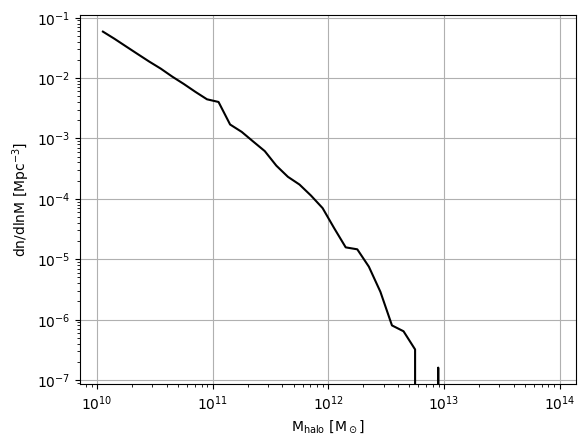

In [55]:
plt.plot(mass_mean, hmf, color='black')

# Make plot pretty
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\rm M_{\rm halo}~[M_\odot]$')
plt.ylabel(r'$\rm dn/dlnM~[Mpc^{-3}]$')
plt.grid()
plt.show()

Now let's plot all of them in the same plot

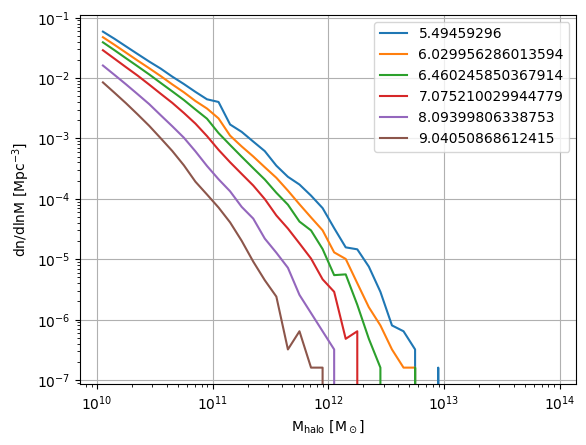

In [50]:
fig, ax = plt.subplots()

for redshift in halo_data_redshifts: 
    hmass_arr = hdf['halo_data'][redshift]['halo_masses'][:]
    hmf = mass_mean * np.histogram(hmass_arr, bins=bins_mass)[0]/(dM*BoxSize**3)
    ax.plot(mass_mean, hmf, label = redshift)
    
# Make plot pretty 
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\rm M_{\rm halo}~[M_\odot]$')
plt.ylabel(r'$\rm dn/dlnM~[Mpc^{-3}]$')
plt.legend()
plt.grid()
plt.show()

### 4.2) UV Luminosity Function <a class="anchor" id="uvlf2"></a>

In [69]:
halo_data_redshifts = list(hdf['halo_data'].keys())
print('The available redshifts to access the halo data are:', halo_data_redshifts)


The available redshifts to access the halo data are: ['5.49459296', '6.029956286013594', '6.460245850367914', '7.075210029944779', '8.09399806338753', '9.04050868612415']


In [70]:
n_halos=30000
hdf_group = hdf['halo_data'][halo_data_redshifts[0]]
total_number_of_halos = len(hdf_group['halo_masses'][:])
print('Total number of halos:', total_number_of_halos)

Total number of halos: 1454609


In [71]:
hm_cat, sm_cat, sfr_cat = d_get_properties.get_properties(redshift     = halo_data_redshifts[0], 
                                                          n_halos      = n_halos, 
                                                          random_seed  = hdf.attrs['random_seed'], 
                                                          hdf_group    = hdf_group, 
                                                          cosmo_params = p21c.CosmoParams.new(dict(hdf['simulation_parameters']['cosmo_params'].attrs)), 
                                                          user_params  = p21c.UserParams.new(dict(hdf['simulation_parameters']['user_params'].attrs)), 
                                                          flag_options = p21c.FlagOptions.new(dict(hdf['simulation_parameters']['flag_options'].attrs)), 
                                                          astro_params = p21c.AstroParams.new(dict(hdf['simulation_parameters']['astro_params'].attrs)))

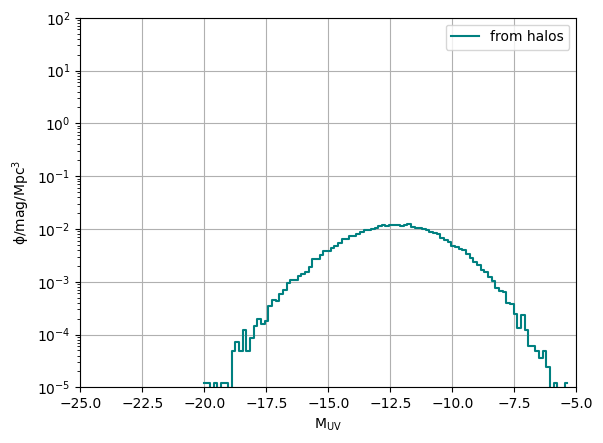

In [83]:
fig, ax = plt.subplots()

Luv_over_SFR = 1.0 / 1.15 / 1e-28

Muv_cat = 51.63 - 2.5*np.log10(sfr_cat*Luv_over_SFR)


hist, bin_edges = np.histogram(Muv_cat, bins=100)
# print(hist,flush=True)
# Compute the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[3]-bin_edges[2]

# Normalize the histogram by the survey volume and bin width (for /mag/Mpc^3)
sim_volume= 300*300*300
hist = hist/ (bin_width * sim_volume)


# Normalize the histogram by the number of sampled halos out of the total number 
hist*= total_number_of_halos/n_halos


ax.plot(bin_centers, hist, drawstyle='steps-mid',color='teal', label='from halos')


# Make the plot look pretty
ax.set_xlabel(r'$\rm M_{UV}$')
ax.set_ylabel(r'$\rm \phi /mag/Mpc^3$')
ax.set_xlim((-25,-5))
ax.set_ylim((1e-5,1e2))
ax.set_yscale('log')
ax.set_yscale('log')
ax.legend()
plt.grid()
plt.show()

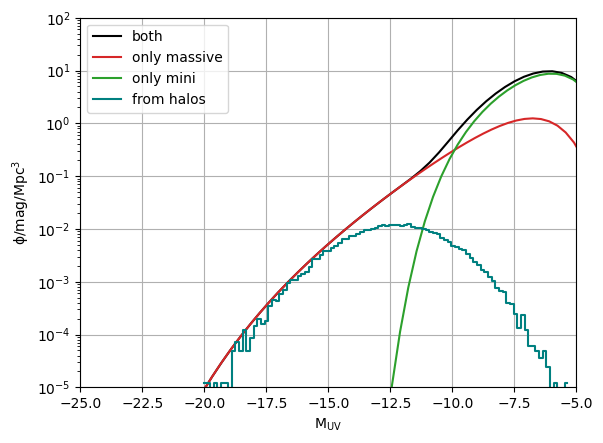

In [82]:
node_redshifts_fid = hdf['coeval_data'].attrs['node_redshifts']
log10_mturnovers = hdf['coeval_data']['log10_mturnovers'][:]
log10_mturnovers_mini = hdf['coeval_data']['log10_mturnovers_mini'][:]

z_uv=node_redshifts_fid  
LF_arr=p21c.compute_luminosity_function(
    redshifts = z_uv,
    inputs=input_params_struct,
    nbins=100,
    mturnovers=10**log10_mturnovers,
    mturnovers_mini=10**log10_mturnovers_mini,
    component='both',
)    
LF_arr_0 = LF_arr[0]
LF_arr_1 = LF_arr[1]
LF_arr_2 = LF_arr[2]


z_id=-1

fig, ax = plt.subplots()
ax.plot(LF_arr_0[z_id,:], 10**LF_arr_2[z_id,:]
        # /LF_arr_0[z_id,:]
        , color='black', label='both')




LF_arr=p21c.compute_luminosity_function(
    redshifts = z_uv,
    inputs=input_params_struct,
    nbins=100,
    mturnovers=10**log10_mturnovers,
    mturnovers_mini=10**log10_mturnovers_mini,
    component='acg',
)    
LF_arr_0 = LF_arr[0]
LF_arr_1 = LF_arr[1]
LF_arr_2 = LF_arr[2]

ax.plot(LF_arr_0[z_id,:], 10**LF_arr_2[z_id,:]
        # /LF_arr_0[z_id,:]
        , color='tab:red', label='only massive')

LF_arr=p21c.compute_luminosity_function(
    redshifts = z_uv,
    inputs=input_params_struct,
    nbins=100,
    mturnovers=10**log10_mturnovers,
    mturnovers_mini=10**log10_mturnovers_mini,
    component='mcg',
)    
LF_arr_0 = LF_arr[0]
LF_arr_1 = LF_arr[1]
LF_arr_2 = LF_arr[2]

ax.plot(LF_arr_0[z_id,:], 10**LF_arr_2[z_id,:]
        # /LF_arr_0[z_id,:]
        , color='tab:green', label='only mini')


Luv_over_SFR = 1.0 / 1.15 / 1e-28

Muv_cat = 51.63 - 2.5*np.log10(sfr_cat*Luv_over_SFR)


hist, bin_edges = np.histogram(Muv_cat, bins=100)
# print(hist,flush=True)
# Compute the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[3]-bin_edges[2]

# Normalize the histogram by the survey volume and bin width (for /mag/Mpc^3)
sim_volume= 300*300*300
hist = hist/ (bin_width * sim_volume)


# Normalize the histogram by the number of sampled halos out of the total number
# All the halos are: 264636275
hist*= total_number_of_halos/n_halos



# fig2, ax2 = plt.subplots()

# Plot the luminosity function (log-log plot)
# plt.figure(figsize=(8, 6))
ax.plot(bin_centers, hist, drawstyle='steps-mid',color='teal', label='from halos')


# Make the plot look pretty
ax.set_xlabel(r'$\rm M_{UV}$')
ax.set_ylabel(r'$\rm \phi /mag/Mpc^3$')


ax.set_xlim((-25,-5))
ax.set_ylim((1e-5,1e2))
ax.set_yscale('log')
ax.set_yscale('log')
ax.legend()
plt.grid()
plt.show()

### 4.3) Stellar Halo Mass Relation (Mstar vs Mhalo) <a class="anchor" id="starrng"></a>

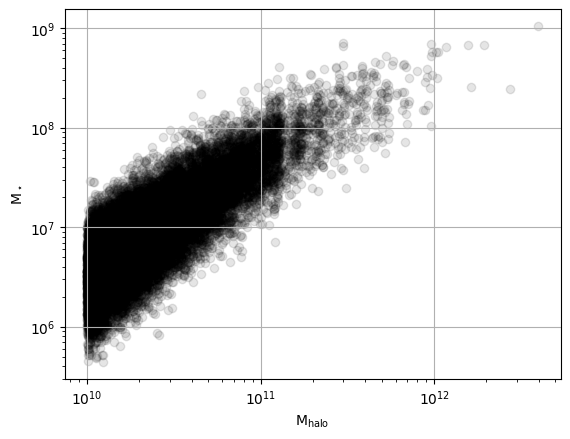

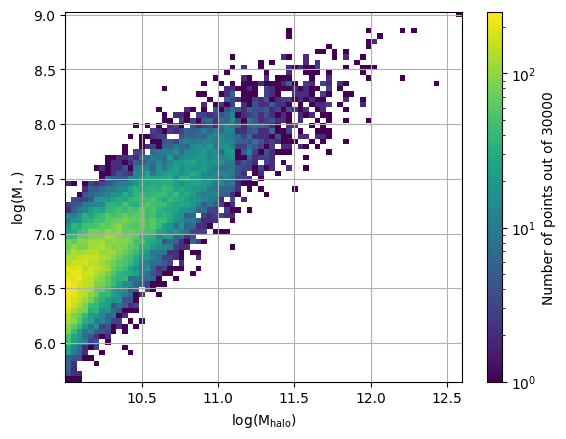

In [77]:
# Mstar vs Mhalo----------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.scatter(hm_cat,sm_cat,color='black', alpha=0.1)
# plt.title(label=r'$\rm M_{star} \; vs \; M_{halo}$')
plt.xlabel(r'$\rm M_{halo}$')
plt.ylabel(r'$\rm M_\star$')
plt.yscale('log')
plt.xscale('log')
plt.grid()

fig, ax = plt.subplots()
plt.hist2d(np.log10(hm_cat), np.log10(sm_cat),bins=70,alpha=1,
                     cmap='viridis',
                      norm='log'
                    )
plt.xlabel(r'$\rm log(M_{halo})$')
plt.ylabel(r'$\rm log(M_\star)$')
plt.colorbar(label=f'Number of points out of {n_halos}', aspect=25)
plt.grid()


### 4.4) Star Formation Main Sequence (SFR vs Mstar) <a class="anchor" id="sfrrng"></a>

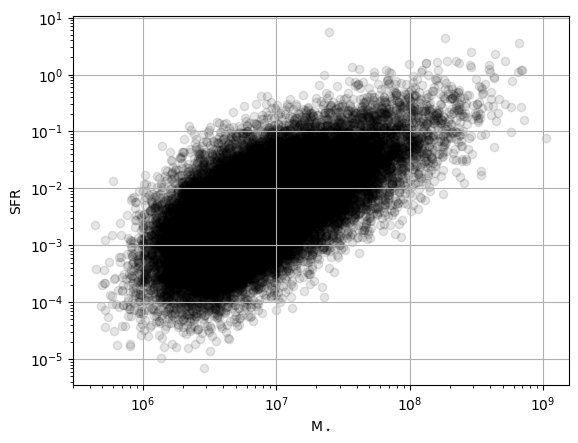

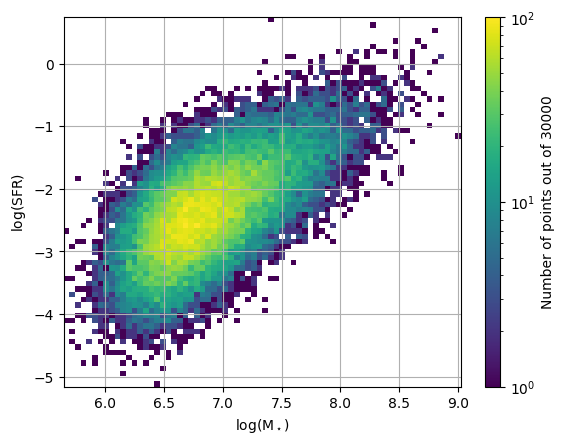

In [79]:
# SFR vs Mstar----------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.scatter(sm_cat,sfr_cat,color='black', alpha=0.1)
# plt.title(label=r'$\rm M_{star} \; vs \; M_{halo}$')
plt.xlabel(r'$\rm M_\star$')
plt.ylabel(r'$\rm SFR$')
plt.yscale('log')
plt.xscale('log')
plt.grid()

fig, ax = plt.subplots()
plt.hist2d(np.log10(sm_cat), np.log10(sfr_cat),bins=70,alpha=1,
                     cmap='viridis',
                      norm='log'
                    )
plt.xlabel(r'$\rm log(M_\star)$')
plt.ylabel(r'$\rm log(SFR)$')
plt.colorbar(label=f'Number of points out of {n_halos}', aspect=25)
plt.grid()

# END OF NOTEBOOK

# GARBAGE

Text(0, 0.5, 'y-axis [Mpc]')

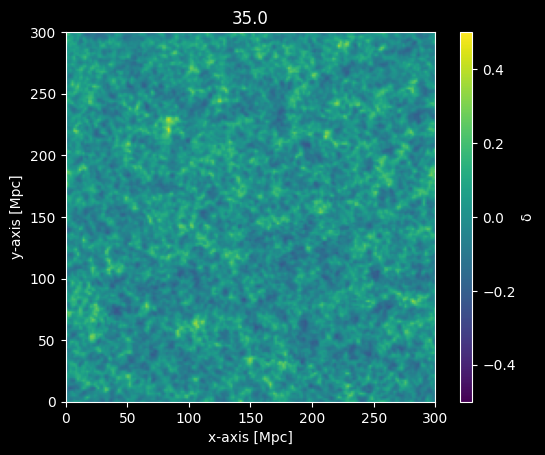

In [49]:
# Maybe also a slice
i=2551
fig, ax = plt.subplots()
plt.imshow(density_lightcone[:,:,i],cmap='viridis',extent=[0,300,0,300]
           ,vmin=-0.5,vmax=0.5
          )
plt.colorbar(shrink=1, aspect=30, label=r'$\rm \delta$')
# plt.title(f'{round(lightcone_redshifts[i], 2)}')
plt.title("{:.1f}".format(round(lightcone_redshifts[i], 2)))
plt.xlabel('x-axis [Mpc]')
plt.ylabel('y-axis [Mpc]')

In [ ]:
print('ok')

In [54]:
# Make a little movie
import imageio
for i in range(2553):
    print(i)
    # Maybe also a slice
    fig, ax = plt.subplots()
    plt.imshow(density_lightcone[:,:,i],cmap='viridis',extent=[0,300,0,300]
               ,vmin=-0.5,vmax=0.5
              )
    plt.colorbar(shrink=1, aspect=30, label=r'$\rm \delta$')
    plt.title("{:.1f}".format(round(lightcone_redshifts[i], 2)))
    plt.xlabel('x-axis [Mpc]')
    plt.ylabel('y-axis [Mpc]')
    plt.savefig(f'/home/ntriantafyllou/projects/constrain21/images/movies/frames_evolve_density/dark_delta_{i}.png', bbox_inches='tight')
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
import imageio
frames = []
for i in range(2551,-1,-1):
    image = imageio.imread(f'/home/ntriantafyllou/projects/constrain21/images/movies/frames_evolve_density/dark_delta_{i}.png')
    frames.append(image)
#     image = image.convert("RGB")  # Convert to RGB if necessary
#     frames.append(np.array(image))  # Convert to a numpy array
imageio.mimsave('/home/ntriantafyllou/projects/constrain21/images/movies/evolve_dark_delta_id_22.gif', # output gif
                frames,          # array of input frames
                fps = 30,
               loop=0)         # optional: frames per second

/var/tmp/pbs.341370.pbs01/ipykernel_341514/1537033701.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f'/home/ntriantafyllou/projects/constrain21/images/movies/frames_evolve_density/dark_delta_{i}.png')


In [21]:
lightcone_redshifts

array([ 5.00000001,  5.0027922 ,  5.00558631, ..., 34.95792128,
       34.99885976, 35.03986848])

In [27]:
# plt.style.use("dark_background")

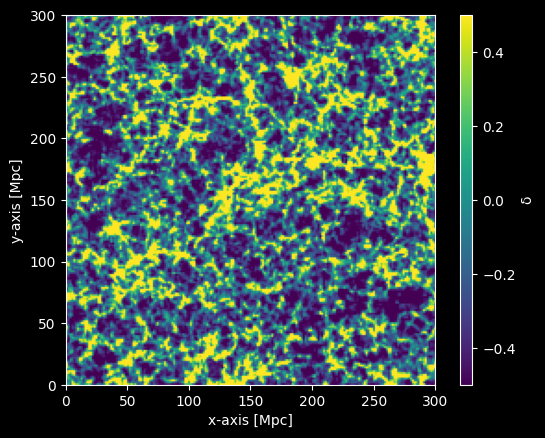

In [29]:
# # Maybe also a slice
# fig, ax = plt.subplots()
# plt.imshow(density_lightcone[:,:,0],cmap='viridis',extent=[0,300,0,300]
#            ,vmin=-0.5,vmax=0.5
#           )
# plt.colorbar(shrink=1, aspect=30, label=r'$\rm \delta$')
# plt.xlabel('x-axis [Mpc]')
# plt.ylabel('y-axis [Mpc]')
# plt.show()

In [39]:
redshift     = halo_data_redshifts[0]
n_halos      = n_halos 
random_seed  = hdf.attrs['random_seed'] 
hdf_group    = hdf_group 
cosmo_params = p21c.CosmoParams.new( dict(hdf['simulation_parameters']['cosmo_params'].attrs) ) 
user_params  = p21c.UserParams.new(dict(hdf['simulation_parameters']['user_params'].attrs)) 
flag_options = p21c.FlagOptions.new(dict(hdf['simulation_parameters']['flag_options'].attrs)) 
astro_params = p21c.AstroParams.new(dict(hdf['simulation_parameters']['astro_params'].attrs))

In [43]:
cosmo_params.cstruct

<cdata 'struct CosmoParams *' owning 24 bytes>

In [44]:
#     pt_halos_ = perturbed_halo_field
#fake pt_halos
# n_halos = 1000000

z=redshift
pt_halos = p21c.PerturbHaloField(
                redshift= redshift,
                random_seed = random_seed,
                user_params = user_params,
                cosmo_params = cosmo_params,
                astro_params = astro_params,
                flag_options = flag_options,
                buffer_size = n_halos
        )
setattr(pt_halos,"n_halos",n_halos)

pt_halos()
random_indices = np.random.choice(len(hdf_group['halo_masses'][:]), size=n_halos, replace=False)
# Use the random indices to select elements
pt_halos.halo_masses[...] = hdf_group['halo_masses'][:][random_indices]
pt_halos.star_rng[...] = hdf_group['star_rng'][:][random_indices]
pt_halos.sfr_rng[...] = hdf_group['sfr_rng'][:][random_indices]
#     pt_halos.xray_rng[...] = pt_halos_.xray_rng[random_indices]
pt_halos()


zero_array = ffi.cast("float *", np.zeros(1).ctypes.data)
props_out = np.zeros(int(1e5)).astype('f4')
lib.test_halo_props(
        float(z),
        user_params.cstruct,
        cosmo_params.cstruct,
        astro_params.cstruct,
        flag_options.cstruct,
        zero_array,
        zero_array,
        zero_array,
        zero_array,
        pt_halos(),
        ffi.cast("float *", props_out.ctypes.data),
)

2025-01-17 18:55:35 | DEBUG   | HaloBox.c       | test_halo_props:795 [pid=336038/thr=0] | Getting props for 100 halos at z=5.49
2025-01-17 18:55:35 | DEBUG   | HaloBox.c       | test_halo_props:879 [pid=336038/thr=0] | Done.


0

In [27]:
type(zero_array)

_cffi_backend._CDataBase

In [30]:
float(z)

5.49459296